In [1]:
import optuna
from optuna.importance import get_param_importances
import pickle
import torch
import os
import sys
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd
from matplotlib.ticker import MultipleLocator
from scipy.optimize import linear_sum_assignment


# Add the root folder to Python path
root_folder = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_folder not in sys.path:
    sys.path.append(root_folder)
from lib.misc_util import open_bundle
import lib.unet_nn as UNet
import lib.modified_aggregation as MA
from lib.modified_aggregation_clusterer import ModifiedAggregationClusterer
from lib.unet_clusterer import UNetClusterer
from lib.focal import FocalH
from lib.base_nn import Data
from lib import metrics# import count_clusters, count_labels, compute_score, total, separation_efficiency

os.chdir('/home/bjartur/workspace/python_focalh_clustering/') # Laptop and Desktop

In [2]:
def get_study(filename):
    with open(filename, "rb") as f:
        loaded_bundle = pickle.load(f)
    return loaded_bundle
    
kmeans_study = open_bundle("studies/best/kmeans/"+"study_kmeans_train_tiny_sep_100.pkl")
ma_single_study = open_bundle("studies/best/ma/"+"study_ma_train_single_sep_100.pkl")
ma_many_study = open_bundle("studies/best/ma/"+"study_ma_train_small_sep_100.pkl")
gmm_study = open_bundle("studies/best/gmm/"+"study_gauss_train_tiny_sep_100.pkl")
dbscan_single_study = open_bundle("studies/best/dbscan/"+"study_dbscan_train_single_sep_100.pkl")
dbscan_many_study = open_bundle("studies/best/dbscan/"+"study_dbscan_train_small_sep_100.pkl")
hdbscan_single_study = open_bundle("studies/best/hdbscan/"+"study_hdbscan_train_single_sep_100.pkl")
hdbscan_many_study = open_bundle("studies/best/hdbscan/"+"study_hdbscan_train_small_sep_100.pkl")
affinity_propagation_single_study = open_bundle("studies/best/affinity_propagation/"+"study_affinity_propagation_train_single_sep_100.pkl")
affinity_propagation_many_study = open_bundle("studies/best/affinity_propagation/"+"study_affinity_propagation_train_tiny_sep_100.pkl")
agglomerative_study = open_bundle("studies/best/agglomerative/"+"study_agglomerative_train_tiny_sep_100.pkl")
birch_study = open_bundle("studies/best/birch/"+"study_birch_train_tiny_sep_100.pkl")
optics_study = open_bundle("studies/best/optics/"+"study_optics_train_tiny_sep_100.pkl")
spectral_study = open_bundle("studies/best/spectral/"+"study_spectral_train_tiny_sep_100.pkl")
cnn_single_study = open_bundle("studies/best/cnn/"+"study_cnn_train_single_small_sep_100.pkl")
cnn_many_study = open_bundle("studies/best/cnn/"+"study_cnn_train_tiny_sep_100.pkl")


Best params: {'trans::type': 'multiply', 'trans::factor': 10, 'trans::width': 1.4525251, 'method::init': 'k-means++', 'method::n_init': 59, 'method::max_iter': 343, 'method::tol': 0.7287947843044579}


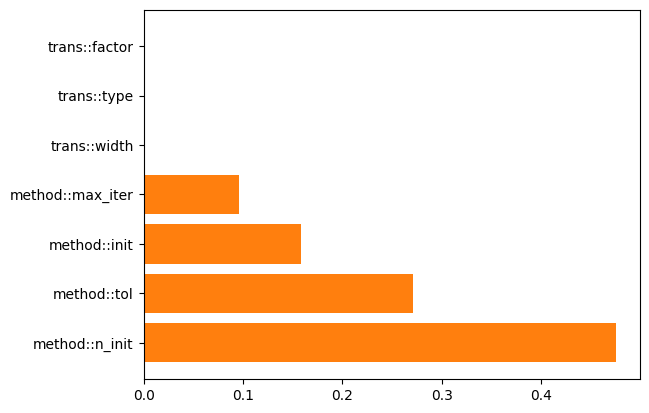

In [47]:
def plot_study(study):
    print(f"Best params: {study.best_params}")
    df = study.trials_dataframe()
    imp = optuna.importance.get_param_importances(study)
    fig,ax = plt.subplots()
    ax.scatter(df["number"], df["value"], marker=".")

    params = list(imp.keys())
    importances = list(imp.values())
    ax.barh(params, importances)

plot_study(study["study"])

In [8]:
s = "method::adsf"
result = s.removeprefix("method::")
print(result)  # Output: adsf


adsf


{'seed': 1564.4170876320618, 'agg': 0.9440790685802705}


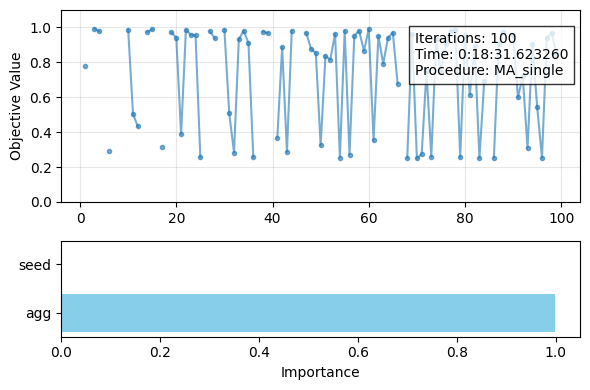

{'seed': 821.8973150028648, 'agg': 13.757066447401392}


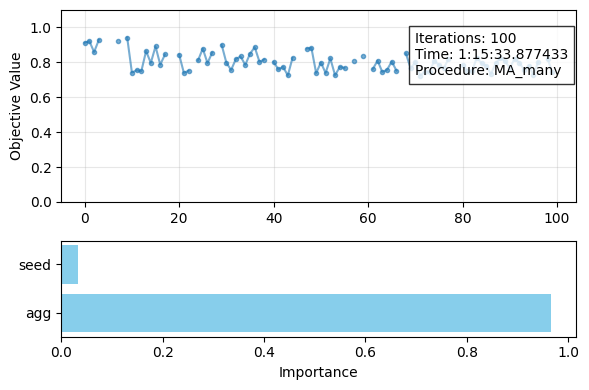

{'seed': 0.2, 'agg': 0.0, 'lr': 0.08158797603987934, 'momentum': 0.8218647787721285, 'epochs': 65}


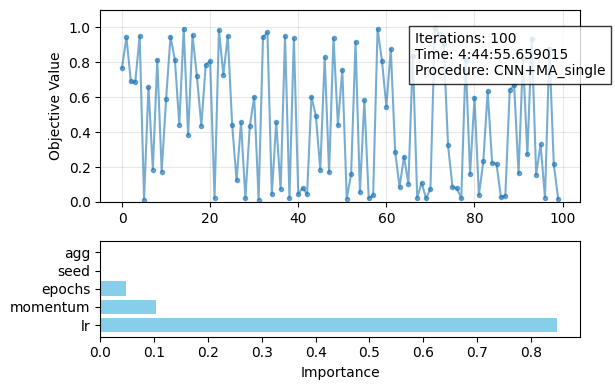

{'seed': 0.2, 'agg': 0.0, 'lr': 0.9414268915592542, 'momentum': 0.7372510633594466, 'epochs': 96}


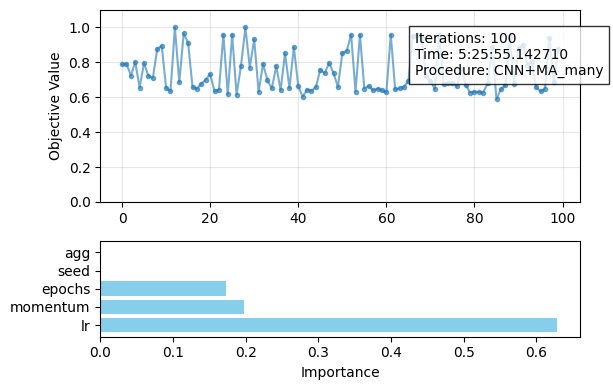

{'trans::type': 'multiply', 'trans::factor': 10, 'trans::width': 1.4525251, 'method::eps': 23.688413316593994}


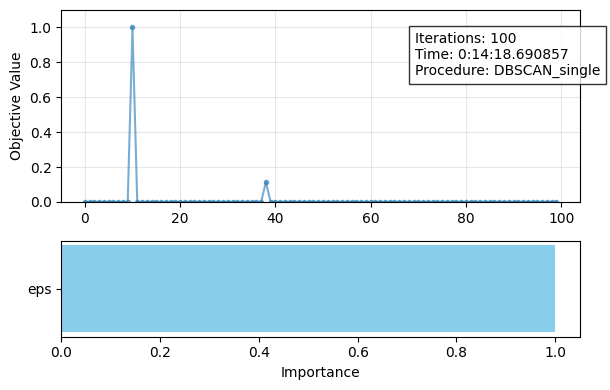

{'trans::type': 'multiply', 'trans::factor': 10, 'trans::width': 1.4525251, 'method::eps': 1.4706802983591263}


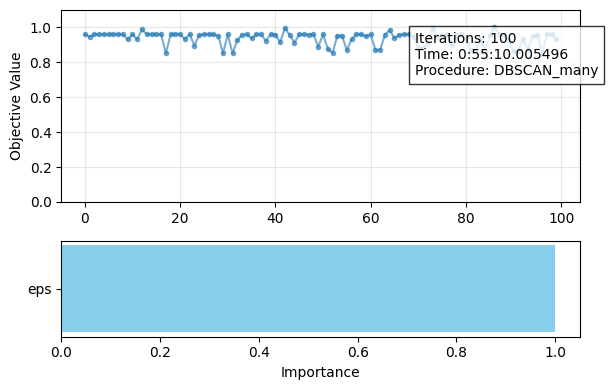

{'trans::type': 'multiply', 'trans::factor': 10, 'trans::width': 1.4525251, 'method::min_samples': 4, 'method::min_cluster_size': 199, 'method::allow_single_cluster': True}


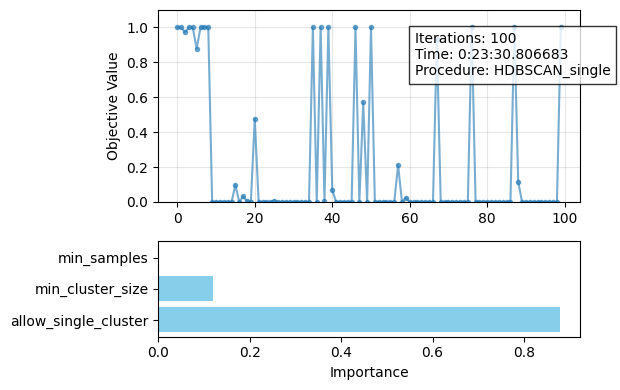

{'trans::type': 'multiply', 'trans::factor': 10, 'trans::width': 1.4525251, 'method::min_samples': 1, 'method::min_cluster_size': 18, 'method::allow_single_cluster': False}


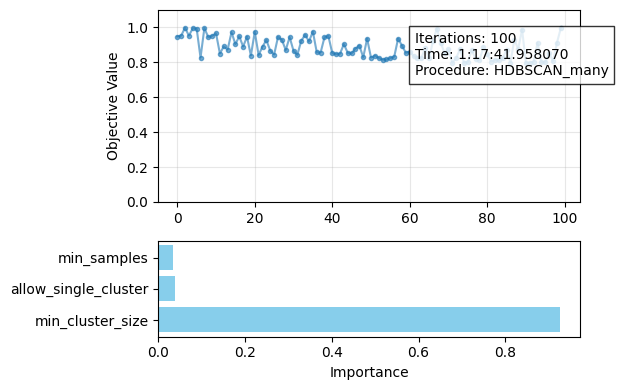

{'trans::type': 'multiply', 'trans::factor': 10, 'trans::width': 1.4525251, 'method::min_samples': 31, 'method::max_eps': 38, 'method::metric': 'euclidean', 'method::xi': 0.010061619308585444, 'method::min_cluster_size': 7, 'method::algorithm': 'kd_tree', 'method::leaf_size': 36}


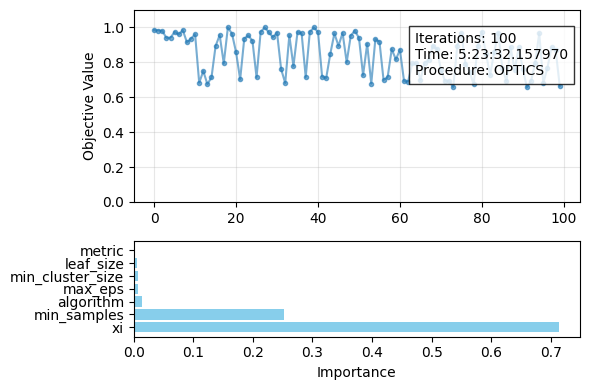

{'trans::type': 'multiply', 'trans::factor': 10, 'trans::width': 1.4525251, 'method::damping': 0.9666344876947125, 'method::max_iter': 179, 'method::convergence_iter': 1, 'method::preference': -191.36023785758866, 'method::affinity': 'euclidean'}


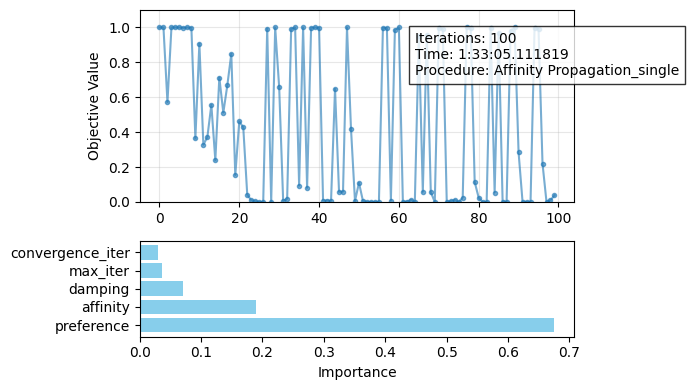

{'trans::type': 'multiply', 'trans::factor': 10, 'trans::width': 1.4525251, 'method::damping': 0.8489005427291453, 'method::max_iter': 22, 'method::convergence_iter': 14, 'method::preference': -174.43007132387453, 'method::affinity': 'euclidean'}


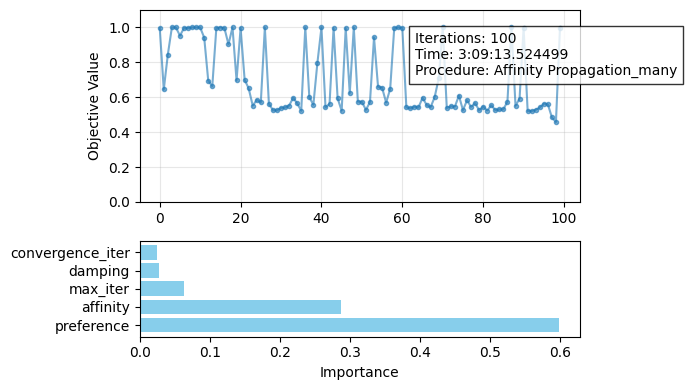

{'trans::type': 'multiply', 'trans::factor': 10, 'trans::width': 1.4525251, 'method::init': 'k-means++', 'method::n_init': 90, 'method::max_iter': 23, 'method::tol': 0.5039159245538402}


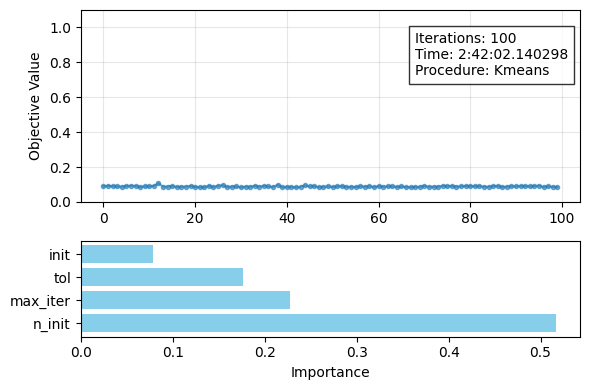

{'trans::type': 'multiply', 'trans::factor': 10, 'trans::width': 1.4525251, 'method::covariance_type': 'full', 'method::reg_covar': 0.007621113870695871, 'method::init_params': 'kmeans', 'method::warm_start': False}


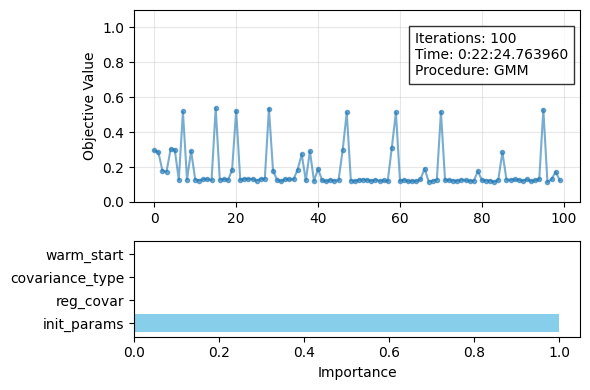

{'trans::type': 'multiply', 'trans::factor': 10, 'trans::width': 1.4525251, 'method::metric': 'manhattan', 'method::linkage': 'complete'}


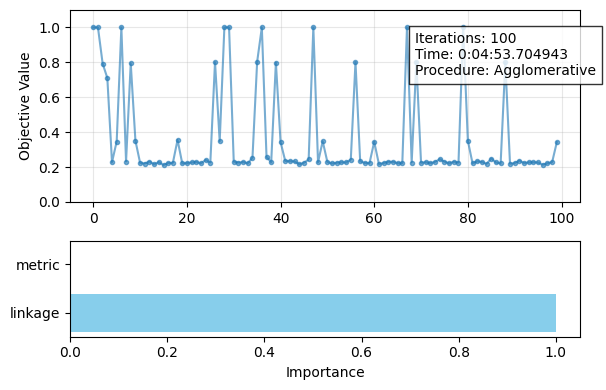

{'trans::type': 'multiply', 'trans::factor': 10, 'trans::width': 1.4525251, 'method::threshold': 0.05434694801048978, 'method::branching_factor': 14, 'method::compute_labels': True}


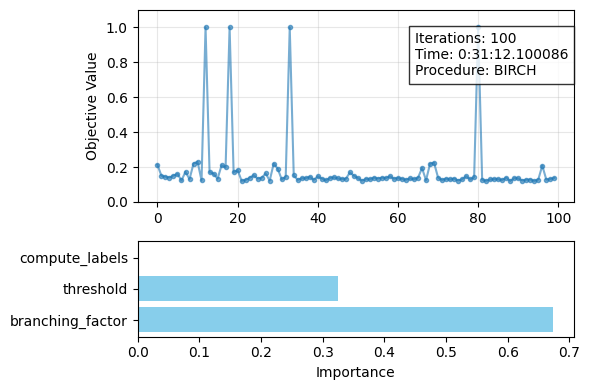

{'trans::type': 'multiply', 'trans::factor': 10, 'trans::width': 1.4525251, 'method::eigen_solver': 'arpack', 'method::affinity': 'nearest_neighbors', 'method::assign_labels': 'cluster_qr'}


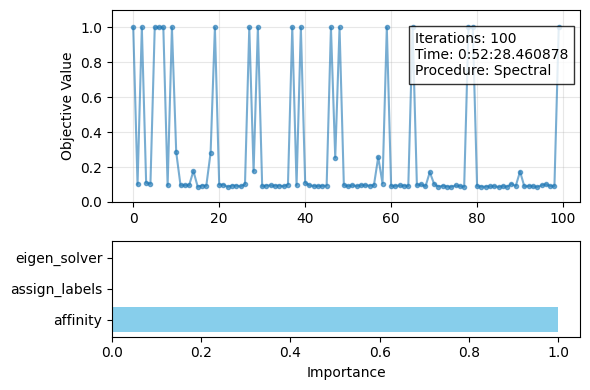

In [10]:
def plot_study_summary(study, procedure_name):

    """
    TO-DO:
        Filter out method:: namespace
        Remove text box and place in title
        Align the sizes of all plots
    """
    
    # --- Data preparation ---
    trials_df = study.trials_dataframe()
    param_importances = get_param_importances(study)
    print(study.best_params)

    # --- Figure setup ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), gridspec_kw={'height_ratios': [2, 1]})

    # --- Convergence plot (top) ---
    ax1.plot(trials_df["number"], trials_df["value"], marker="o", markersize=3, linestyle="-", alpha=0.6)
    ax1.set_ylabel("Objective Value")
#    ax1.set_title(f"Convergence of {procedure_name}")
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0,1.1)
    #ax1.set_yscale("log")

    # --- Parameter importance (bottom) ---
    params = list(param_importances.keys())
    importance = list(param_importances.values())
    tparams = []
    timportance = []
    for i,par in enumerate(params):
        if not par.startswith("trans::"):
            tparams.append(params[i].removeprefix("method::"))
            timportance.append(importance[i])
    params = tparams
    importance = timportance
    ax2.barh(params, importance, color="skyblue")
    ax2.set_xlabel("Importance")
#    ax2.set_title("Parameter Importance")

    # --- Text annotations ---
    n_trials = len(study.trials)
    time_str = f"{study.trials[-1].datetime_complete - study.trials[0].datetime_start}" if n_trials > 0 else "N/A"
    text = (
        f"Iterations: {n_trials}\n"
        f"Time: {time_str}\n"
        f"Procedure: {procedure_name}"
    )
    fig.text(0.7, 0.8, text, bbox=dict(facecolor="white", alpha=0.8))

    # --- Layout ---
    plt.tight_layout()
    plt.savefig("dump/optuna_study_"+procedure_name.lower()+".png", bbox_inches="tight")
    plt.show()

plot_study_summary(ma_single_study["study"], "MA_single")
plt.show()
plot_study_summary(ma_many_study["study"], "MA_many")
plt.show()


plot_study_summary(cnn_single_study["study"], "CNN+MA_single")
plt.show()
plot_study_summary(cnn_many_study["study"], "CNN+MA_many")
plt.show()


plot_study_summary(dbscan_single_study["study"], "DBSCAN_single")
plt.show()
plot_study_summary(dbscan_many_study["study"], "DBSCAN_many")
plt.show()


plot_study_summary(hdbscan_single_study["study"], "HDBSCAN_single")
plt.show()
plot_study_summary(hdbscan_many_study["study"], "HDBSCAN_many")
plt.show()

plot_study_summary(optics_study["study"], "OPTICS")
plt.show()

plot_study_summary(affinity_propagation_single_study["study"], "Affinity Propagation_single")
plt.show()
plot_study_summary(affinity_propagation_many_study["study"], "Affinity Propagation_many")
plt.show()


plot_study_summary(kmeans_study["study"], "Kmeans")
plt.show()
plot_study_summary(gmm_study["study"], "GMM")
plt.show()
plot_study_summary(agglomerative_study["study"], "Agglomerative")
plt.show()
plot_study_summary(birch_study["study"], "BIRCH")
plt.show()
plot_study_summary(spectral_study["study"], "Spectral")


In [33]:
agglomerative_study["study"].best_params

{'trans::type': 'multiply',
 'trans::factor': 10,
 'trans::width': 1.4525251,
 'method::metric': 'manhattan',
 'method::linkage': 'complete'}